In [1]:
import pandas as pd
import numpy as np
import os
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import itertools
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from feature_engine.selection import DropDuplicateFeatures

from optbinning import BinningProcess, OptimalBinning

from catboost import CatBoostClassifier

(CVXPY) Oct 25 03:19:18 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 25 03:19:18 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## 1. Load data

For our analysis, we will use the training dataset located at `./data/train.csv`

This Dataset is the training dataset in a Hackathon organized by Deloitte. The aim is to predict whether a person will be a loan defaulter or not by looking at various attributes like funded amount, location, loan, balance, etc. In reality, banks and finance institutions would create credit scorecards for such tasks and rank their customers by credit score.

In this analysis, we will focus more on exploratory data analysis to find out the top 10 variables contributing most significantly to the probability of default. Our task is to explore the relationship between the independent variables and the target variable, perform some transformation and encoding techniques to have a dataset ready for fitting into a logistic regression model.

In [3]:
df = pd.read_csv('./data/train.csv')

df.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


Brief description of columns:

- `ID`: unique ID of representative
- `Loan Amount`: loan amount applied
- `Funded Amount`: loan amount funded
- `Funded Amount Investor`: loan amount approved by the investors
- `Term`: term of loan (in months)
- `Batch Enrolled`: batch numbers to representatives
- `Interest Rate`: interest rate (%) on loan
- `Grade`: grade by the bank
- `Sub Grade`: sub-grade by the bank
- `Employment Duration`: duration
- `Home Ownership`: Ownership of home
- `Verification Status`: Income verification by the bank
- `Payment Plan`: if any payment plan has started against loan
- `Loan Title`: loan title provided
- `Debit to Income`: ratio of representative's total monthly debt repayment divided by self reported monthly income excluding mortgage
- `Delinquency - two years`: number of 30+ days delinquency in past 2 years
- `Inquiries - six months`: total number of inquiries in last 6 months
- `Open Account`: number of credit line in representative's credit line
- `Public Records`: number of derogatory public records
- `Revolving Balance`: total credit revolving balance
- `Revolving Utilities`: amount of credit a representative is using relative to Revolving Balance
- `Total Accounts`: total number of credit lines available in representative's credit lines
- `Initial List Status`: unique listing status of the loan - W(Waiting), F(Forwarded)
- `Total Received Interest`: total interest received till date
- `Total Received Late Fee`: total late fee received till date
- `Recoveries`: post charge off gross recovery
- `Collection Recovery Fee`: post charge off collection fee
- `Collection 12 months Medical`: total collections in last 12 months excluding medical collections
- `Application Type`: indicates when the representative is an individual or joint
- `Last week Pay`: indicates how long (in weeks) a representative has paid EMI after batch enrolled
- `Accounts Delinquent`: number of accounts on which the representative is delinquent
- `Total Collection Amount`: total collection amount ever owed
- `Total Current Balance`: total current balance from all accounts
- `Total Revolving Credit Limit`: total revolving credit limit
- `Loan Status`: 1 = Defaulter, 0 = Non-defaulter

First, it seems like the data in `Employment Duration` should have been `Home Ownership`. We are not sure what the data in `Home Ownership` would have been, but one possibility is income. So let's rename `Home Ownership` to `Income`

In [4]:
df = df.rename(columns={'Home Ownership': 'Income', 'Employment Duration': 'Home Ownership'})

In [5]:
# let's also convert the variable names to lowercase snake case 
var_names_new = [var.lower().replace('- ', '').replace(' ', '_') for var in df.columns]
df.columns = var_names_new

df.head()

,id,loan_amount,funded_amount,funded_amount_investor,term,batch_enrolled,interest_rate,grade,sub_grade,home_ownership,income,verification_status,payment_plan,loan_title,debit_to_income,delinquency_two_years,inquires_six_months,open_account,public_record,revolving_balance,revolving_utilities,total_accounts,initial_list_status,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,collection_12_months_medical,application_type,last_week_pay,accounts_delinquent,total_collection_amount,total_current_balance,total_revolving_credit_limit,loan_status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


In [6]:
df.head()

,id,loan_amount,funded_amount,funded_amount_investor,term,batch_enrolled,interest_rate,grade,sub_grade,home_ownership,income,verification_status,payment_plan,loan_title,debit_to_income,delinquency_two_years,inquires_six_months,open_account,public_record,revolving_balance,revolving_utilities,total_accounts,initial_list_status,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,collection_12_months_medical,application_type,last_week_pay,accounts_delinquent,total_collection_amount,total_current_balance,total_revolving_credit_limit,loan_status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


In [7]:
# check the number of rows and columns
df.shape

(67463, 35)

In [8]:
# Displays column names, complete (non-missing) cases per column, and datatype per column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            67463 non-null  int64  
 1   loan_amount                   67463 non-null  int64  
 2   funded_amount                 67463 non-null  int64  
 3   funded_amount_investor        67463 non-null  float64
 4   term                          67463 non-null  int64  
 5   batch_enrolled                67463 non-null  object 
 6   interest_rate                 67463 non-null  float64
 7   grade                         67463 non-null  object 
 8   sub_grade                     67463 non-null  object 
 9   home_ownership                67463 non-null  object 
 10  income                        67463 non-null  float64
 11  verification_status           67463 non-null  object 
 12  payment_plan                  67463 non-null  object 
 13  l

In [9]:
# get some descriptive statistics
# for categorical variables, we will also see the number of unique values
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,67463.0,NaN,NaN,NaN,25627607.746498,21091554.023733,1297933.0,6570288.0,17915646.0,42715208.5,72245779.0
loan_amount,67463.0,NaN,NaN,NaN,16848.902776,8367.865726,1014.0,10012.0,16073.0,22106.0,35000.0
funded_amount,67463.0,NaN,NaN,NaN,15770.599114,8150.992662,1014.0,9266.5,13042.0,21793.0,34999.0
funded_amount_investor,67463.0,NaN,NaN,NaN,14621.799323,6785.34517,1114.590204,9831.684984,12793.68217,17807.59412,34999.74643
term,67463.0,NaN,NaN,NaN,58.173814,3.327441,36.0,58.0,59.0,59.0,59.0
batch_enrolled,67463,41,BAT3873588,3626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
interest_rate,67463.0,NaN,NaN,NaN,11.846258,3.718629,5.320006,9.297147,11.377696,14.193533,27.182348
grade,67463,7,C,19085,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,67463,35,B4,4462,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,67463,3,MORTGAGE,36351,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# let's separate the data into target and variables
target = 'loan_status'

y = df[target]
X = df[[var for var in df.columns if var not in [target, 'id']]]

In [11]:
X.shape, y.shape

((67463, 33), (67463,))

## 2. Drop constant, quasi-constant, and duplicate variables

First, let's identify constant and quasi-constant variables in our dataset using a variance threshold. Variables that have lower variance than this threshold will be considered a (quasi)constant variable and will be dropped from the analysis as they will not add any useful information towards whether a person is a defaulter.

We can use `sklearn.feature_selection.VarianceThreshold` to drop features with variance below a certain threshold, but the method is only applicable to numeric variables. If we want to apply the variance threshold method on non-numeric variables, we have to code it ourselves.

In [12]:
class DropQuasiConstantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, predominant_threshold=0.998):
        self.predominant_threshold = predominant_threshold
        # create an empty list to store quasi-constant features
        self.quasi_constant_features = []
        
    def fit(self, X, y=None):
        for feature in X.columns:
            # find the predominant value (shared by most observations):
            predominant = X[feature].value_counts(normalize=True).sort_values(ascending=False).values[0]
            # evaluate the predominant value frequency: does it exceed the threshold?
            if predominant > self.predominant_threshold:
                # if yes, add the feature to the list
                self.quasi_constant_features.append(feature)

        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed.drop(self.quasi_constant_features, axis=1, inplace=True)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [13]:
drop_quasi_constant = DropQuasiConstantFeatures()
# we use the fit method to get the list of quasi-constant variables
quasi_constant_vars = drop_quasi_constant.fit(X).quasi_constant_features

print('Quasi-constant features:', quasi_constant_vars)

Quasi-constant features: ['payment_plan', 'application_type', 'accounts_delinquent']


Let's also check if our dataset contains any duplicated variables, that is, features with different names but are identical in values. Since there is not built-in method for detecting and removing duplicated variables in pandas or sklearn, we'll use a different open-source package `feature_engine` to accomplish this.

In [14]:
# set up a selector using feature_engine.selection.DropDuplicateFeatures
drop_duplicate = DropDuplicateFeatures(variables=None, missing_values='raise')

# find the duplicate features
drop_duplicate.fit(X)

# let's check if there are any pairs of duplicated features
drop_duplicate.duplicated_feature_sets_

[]

Good thing that our dataset does not have any duplicated variables.

## 3. Extract more variables from existing variables

Based on the variables' description, we can extract some more variables from the existing ones.

In [15]:
# loan amount to funded amount ratio
X['loan_amount_to_funded_amount_ratio'] = X['loan_amount'] / X['funded_amount']
# funded amount per month 
X['funded_amount_per_month'] = X['funded_amount'] / X['term']
# open account to total account ratio
X['open_account_to_total_account_ratio'] = X['open_account'] / X['total_accounts']
# recovery rate
X['recovery_rate'] = X['recoveries'] / X['total_collection_amount']
# any inquries in last six months
X['any_inquiries_six_month'] = (X['inquires_six_months'] > 0).astype(int)
# any delinquency last 2 years
X['any_delinquency_two_years'] = (X['delinquency_two_years'] > 0).astype(int)
# sub grade (extract the number part only)
X['sub_grade'] = X['sub_grade'].apply(lambda x: x[-1]).astype(int)
# batch number (extract the number part only)
X['batch_enrolled'] = X['batch_enrolled'].apply(lambda x: x[3:])

/tmp/ipykernel_6201/100914984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['loan_amount_to_funded_amount_ratio'] = X['loan_amount'] / X['funded_amount']


In [16]:
X.head()

,loan_amount,funded_amount,funded_amount_investor,term,batch_enrolled,interest_rate,grade,sub_grade,home_ownership,income,verification_status,payment_plan,loan_title,debit_to_income,delinquency_two_years,inquires_six_months,open_account,public_record,revolving_balance,revolving_utilities,total_accounts,initial_list_status,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,collection_12_months_medical,application_type,last_week_pay,accounts_delinquent,total_collection_amount,total_current_balance,total_revolving_credit_limit,loan_amount_to_funded_amount_ratio,funded_amount_per_month,open_account_to_total_account_ratio,recovery_rate,any_inquiries_six_month,any_delinquency_two_years
0,10000,32236,12329.36286,59,2522922,11.135007,B,4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0.310212,546.372881,1.857143,0.080590,0,1
1,3609,11940,12191.99692,59,1586599,12.237563,C,3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0.302261,202.372881,0.923077,0.044853,0,0
2,28276,9311,21603.22455,59,2136391,12.545884,F,4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,3.036838,157.813559,0.700000,0.126949,0,0
3,11170,6954,17877.15585,59,2428731,16.731201,C,3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,1.606270,117.864407,0.583333,0.002676,0,1
4,16890,13226,13539.92667,59,5341619,15.008300,C,4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,1.277030,224.169492,0.590909,3.011206,1,1


We can split our variables into categorical and numerical ones, excluding the quasi-constant variables.

In [17]:
categorical_vars = [var for var in X.columns if var not in quasi_constant_vars and X[var].dtype=='object']
numerical_vars = [var for var in X.columns if var not in quasi_constant_vars and var not in categorical_vars]

# let's check out the number of categorical variables and numerical variables
print('Number of categorical variables:', len(categorical_vars))
print('Number of numerical variables:', len(numerical_vars))

Number of categorical variables: 6
Number of numerical variables: 30


## 3. Target variable - Loan Status

Let's inspect the target variable - `Loan Status`. This is a binary variable, with `0` = Non-defaulter and `1` = Defaulter.


In [18]:
# the overall default rate
default_perc = sum(y) / y.shape[0]

print(f'The overall default rate is: {default_perc:.4f}')

The overall default rate is: 0.0925


Our dataset is highly imbalanced. The ratio of Non-defaulters to Defaulters is roughly 10:1

## 4. Categorical variables

Let's check out the list of categorical variables and how many unique categories each of them contains.

In [19]:
X[categorical_vars].nunique().sort_values()

initial_list_status      2
home_ownership           3
verification_status      3
grade                    7
batch_enrolled          41
loan_title             109
dtype: int64

In [20]:
for var in categorical_vars:
    print(X[var].value_counts(normalize=True).sort_index())
    print()

batch_enrolled
1104812    0.044410
1135695    0.004388
1184694    0.034063
1467036    0.011888
1586599    0.046574
1761981    0.013252
1766061    0.021656
1780517    0.035620
1930365    0.027334
2003848    0.012481
2078974    0.033945
2136391    0.026533
224923     0.013267
2252229    0.037902
2333412    0.026311
2428731    0.020722
2522922    0.020737
2558388    0.029097
2575549    0.033455
2803411    0.035946
2833642    0.021063
3193689    0.027630
3461431    0.015831
3726927    0.026296
3865626    0.010791
3873588    0.053748
4136152    0.026177
4271519    0.030446
4351734    0.016898
4694572    0.033322
4722912    0.013148
4808022    0.019314
5341619    0.025451
5489674    0.024858
5525466    0.025332
5547201    0.016705
5629144    0.024295
5714674    0.016379
5811547    0.010539
5849876    0.011384
5924421    0.020811
Name: proportion, dtype: float64

grade
A    0.178691
B    0.277812
C    0.282896
D    0.122423
E    0.095549
F    0.033292
G    0.009338
Name: proportion, dtype: fl

We notice that these variables can be divided into 3 groups:
1. Binary Variables
- `intital_list_status`
2. Ordinal Variables
- `grade`  
3. Nominal Variables
-  `home_ownership`
-  `verification_status`
-  `loan_title`
-  `batch_enrolled`

### 4.1. Some data cleaning

Some variables are high-cardinality - `loan_title`. In particular, the inconsistent values in `Loan Title` are likely the result of manual data entry. To properly analyze the data in this variable, we need to clean it.

In [21]:
class LoanTitleCleanUp(BaseEstimator, TransformerMixin):
    def __init__(self, feature='loan_title', rare_threshold=0.01):
        self.feature = feature
        self.rare_threshold = rare_threshold
        
    def fit(self, X, y=None):
        self.mapping = {
            'credit card refinance': 'credit card refinancing',
            'debt consolidation loan': 'debt consolidation',
            'consolidation debt': 'debt consolidation',
            'home buying': 'major purchase',
            'consolidation loan': 'debt consolidation',
            'credit consolidation': 'debt consolidation',
            'credit card consolidation': 'debt consolidation',
            'refi': 'refinance',
            'credit card refi': 'credit card refinancing',
            'refinance loan': 'refinance',
            'consolidationd': 'debt consolidation',
            'home improvement loan': 'home improvement',
            'credit cardrefinance': 'credit card refinancing',
            'conso': 'debt consolidation',
            'loan consolidation': ' debt consolidation',
            'consolidation': 'debt consolidation',
            'car financing': 'major purchase',
        }
        return self
        
    def transform(self, X):
        X_transformed = X.copy()
        # first, let's convert the values to lower case and remove any special characters
        X_transformed[self.feature] = X[self.feature].str.lower().str.replace(r'[^a-z\s]', '', regex=True).str.strip()
        # replace synonyms
        X_transformed[self.feature] = X_transformed[self.feature].str.replace('cc', 'credit card')\
                                    .str.replace('pay off', 'payoff')\
                                    .str.replace('consolidate', 'consolidation')

        # apply the mapping
        X_transformed[self.feature] = X_transformed[self.feature].replace(self.mapping)

        # Handle rare categories
        frequencies = X_transformed[self.feature].value_counts(normalize=True)
        X_transformed[self.feature] = X_transformed[self.feature].apply(lambda x: 'other' if frequencies[x] < self.rare_threshold else x)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [22]:
# test the transformer - we want to set up a pipeline that can be reused later so for now, we will not overwrite X with our fit & transform method
loan_title_clean = LoanTitleCleanUp('loan_title', 0.01)

X_trans = loan_title_clean.fit_transform(X)

X_trans['loan_title'].value_counts(normalize=True).sort_values(ascending=False)

loan_title
credit card refinancing    0.457510
debt consolidation         0.432252
other                      0.065428
home improvement           0.034197
major purchase             0.010613
Name: proportion, dtype: float64

After data cleaning, our `loan_title` variable has much fewer unique values. The top 2 categories are `credit card refinancing` and `debt consolidation`

Let's begin encoding our categorical variables

### 4.2. Ordinal Variables
We start with the 1 ordinal variable - `grade` since they should be the most straightforward. For this variables, it makes sense to replace the string labels with integer representation that captures the order of the values.

In [23]:
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
        self.mappings = {}

    def fit(self, X, y=None):
        for feature in self.features:
            mapping = {k:i for i,k in enumerate(sorted(X[feature].unique()), 0)}
            self.mappings[feature] = mapping
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.features:
            mapping = self.mappings[feature]
            X_transformed[feature] = X[feature].map(mapping)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self    

In [24]:
cat_ordinal_features = ['grade']

cat_ordinal_enc = CustomOrdinalEncoder(features=cat_ordinal_features)

### 4.3. Weight of Evidence encoding

One encoding method typically used in credit scoring is Weight of Evidence, which quantifies the relationship between a category of a variable and a binary target. In other words, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default).. In doing so, it also creates a monotonic relationships between the encoded variable and the target, which works better with our linear models.

The formula for calculting WoE for a category within a variable is as follows:

$$WOE = ln(\frac {\text{Distribution of events}} {\text{Distribution of non-events}})$$

WoE is well suited for Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

The WoE transformation has three advantages:

- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

While WoE can handle categorical variables with many categories, but for extremely high cardinality variables (e.g., `Loan Title`), it's better to reduce the number of categories through discretization or grouping several categories together, which also helps ensure sufficient data per category for more stable results.

Let's apply Weight of Evidence on our categorical variables (except for `Batch Enrolled`, we'll deal with this variable later). We'll use the library `optbinning` to help us with both the binning and the WoE transformation.

We'll create a custom `WoETransformer` that inherits from sklearn's `BaseEstimator` and `TransformerMixin`.

In [25]:
class WoETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features, dtype='categorical', solver='cp', monotonic_trend='auto', 
                 # missing_values=None, special_values=None,
                 user_splits=None, user_splits_fixed=None):
        self.features = features
        self.dtype = dtype
        self.solver = solver
        self.monotonic_trend = monotonic_trend
        self.user_splits = user_splits or {}
        self.user_splits_fixed = user_splits_fixed or {}
        # self.missing_values = missing_values or []
        # self.special_values = special_values or []
        self.bin_models = {}

    # here we overwrite the fit method with our own fit method using OptimalBinning 
    def fit(self, X, y=None):
        for feature in self.features:
            # check if user splits for this feature is defined
            user_splits_ = self.user_splits.get(feature)
            user_splits_fixed_ = self.user_splits_fixed.get(feature)
            optb = OptimalBinning(name=feature, dtype=self.dtype, 
                                  user_splits=user_splits_, user_splits_fixed=user_splits_fixed_,
                                  solver=self.solver, monotonic_trend=self.monotonic_trend)
            optb.fit(X[feature], y)
            self.bin_models[feature] = optb     # save this to the transformer's bin models for access later in transformation
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.features:
            optb = self.bin_models[feature]
            X_transformed[feature] = optb.transform(X[feature], metric='woe')    # use empirical WoE to transform missing values
        return X_transformed

In [26]:
# we'll start with the ordinal variables
# ordinal_features = ['Grade', 'Sub Grade']

# create the transformer for these feature
cat_ordinal_woe = WoETransformer(features=cat_ordinal_features,
                                         dtype='numerical',            # dtype is numerical for ordinal variables
                                         solver='cp',
                                         monotonic_trend='ascending',  # we want to enforce a monotonic trend where default rate increases as the value increases
                                        )

In [27]:
# for the remaining nominal and binary features
cat_nominal_features = [var for var in categorical_vars if var not in cat_ordinal_features]

# we define custom splits for Loan Title
user_splits = {
    'loan_title': np.array([
        ['debt consolidation'],
        ['credit card refinancing'],
        ['other', 'major purchase', 'home improvement']
    ], dtype=object)
}

user_splits_fixed = {
    'loan_title': [True, True, True]
}

# create the transformer for these feature
cat_nominal_woe = WoETransformer(features=cat_nominal_features,
                                         dtype='categorical',            # dtype is categorical for nominal variables
                                         solver='cp',
                                         monotonic_trend='auto',
                                         user_splits=user_splits,
                                         user_splits_fixed=user_splits_fixed
                                        )

In [28]:
# Create the pipeline for categorical variables, we'll do the fit and transform later
cat_pipeline = Pipeline(steps=[
    ('loan_title_clean', loan_title_clean),
    # ('batch_num_extract', batch_num_extract),
    ('cat_ordinal_enc', cat_ordinal_enc),
    ('cat_ordinal_woe', cat_ordinal_woe),
    ('cat_nominal_woe', cat_nominal_woe)
])

In [29]:
# X_trans_cat = cat_woe_pipeline.fit_transform(X, y)

In [30]:
# X_trans_cat.head()

## 5. Numerical Variables

Let's also see whether these variables are correlated to each other.

In [31]:
numerical_vars

['loan_amount',
 'funded_amount',
 'funded_amount_investor',
 'term',
 'interest_rate',
 'sub_grade',
 'income',
 'debit_to_income',
 'delinquency_two_years',
 'inquires_six_months',
 'open_account',
 'public_record',
 'revolving_balance',
 'revolving_utilities',
 'total_accounts',
 'total_received_interest',
 'total_received_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'collection_12_months_medical',
 'last_week_pay',
 'total_collection_amount',
 'total_current_balance',
 'total_revolving_credit_limit',
 'loan_amount_to_funded_amount_ratio',
 'funded_amount_per_month',
 'open_account_to_total_account_ratio',
 'recovery_rate',
 'any_inquiries_six_month',
 'any_delinquency_two_years']

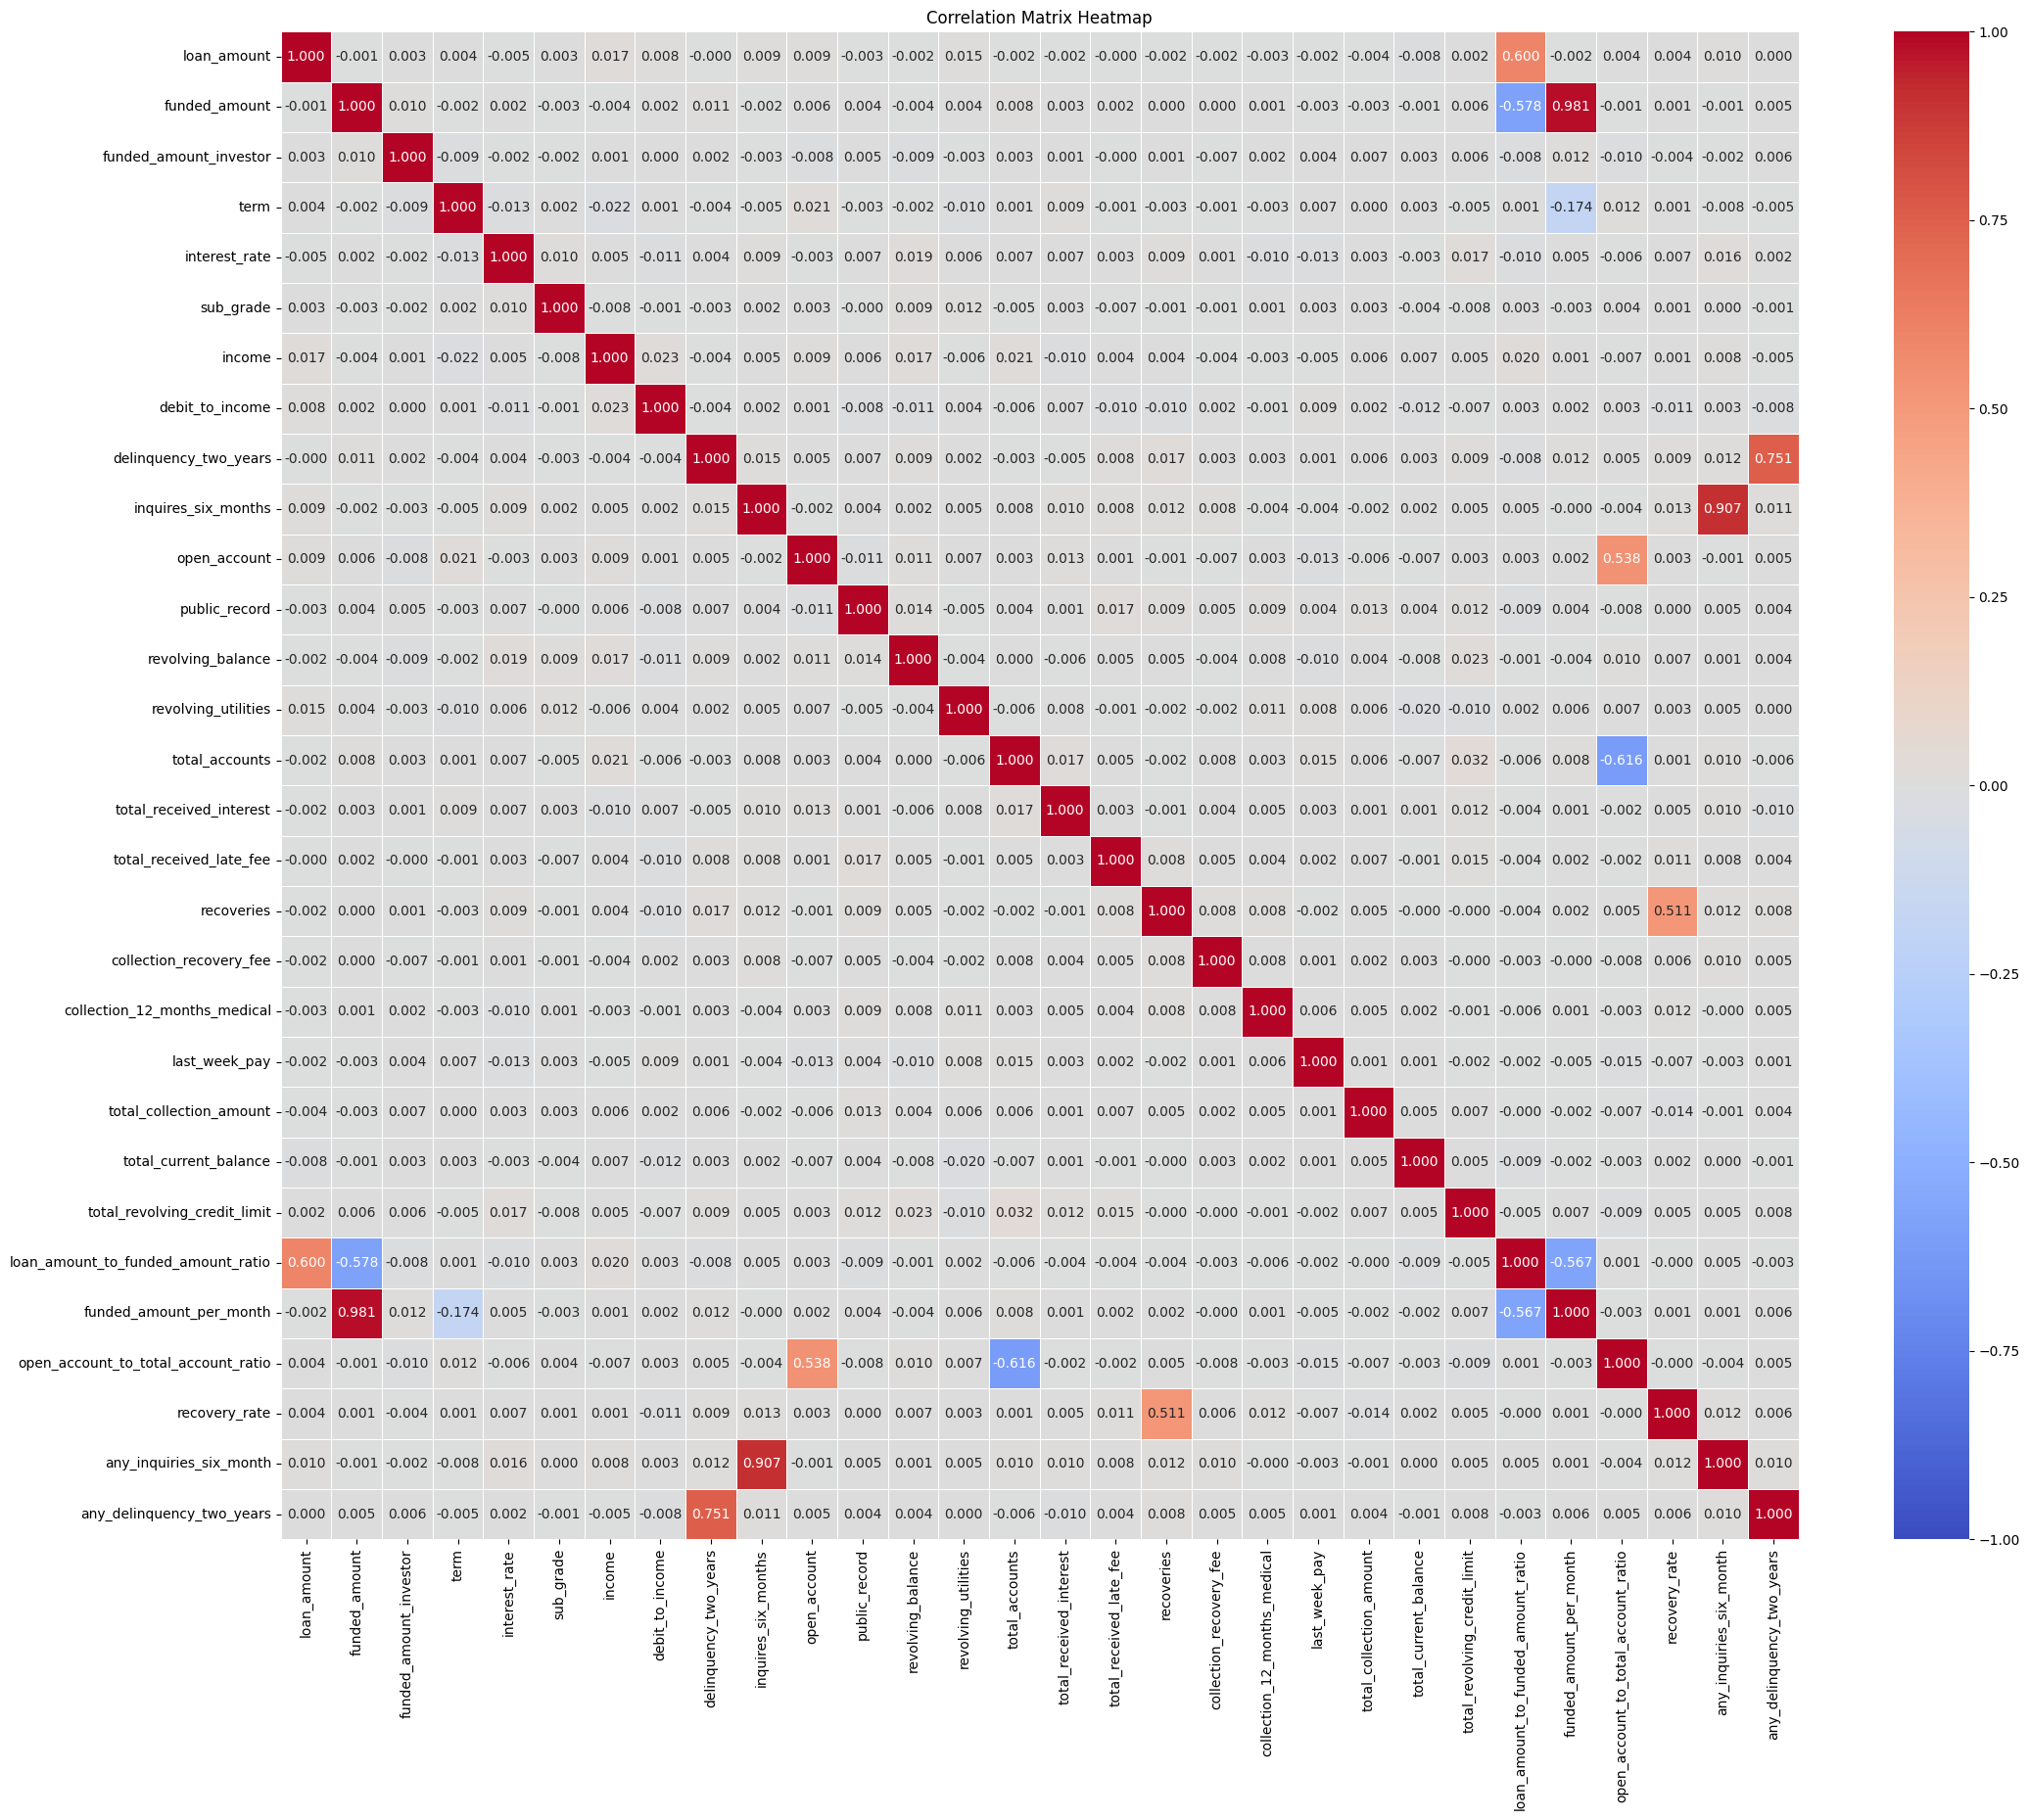

In [35]:
# calculate the correlation among continuous variables
X_corr = X[numerical_vars].corr()

# plot the heatmap of feature correlation
plt.figure(figsize=(25,20))
sns.heatmap(X_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=.5, fmt='.3f')
plt.title('Correlation Matrix Heatmap')
plt.show()

We can see that other than the extra variables we created being highly correlated with the existing variables used to create them (which makes obvious sense), the majority of our numerical variables are not highly correlated with each other.

### 5.1. Discrete numerical variables

In [33]:
# we select the numerical variables with fewer than 20 unique values and is not one of the constant variables that we already spotted
discrete_num_vars = [var for var in numerical_vars if X[var].nunique() < 20]

# let check the number of unique values in these variables
X[discrete_num_vars].nunique().sort_values()

collection_12_months_medical    2
any_inquiries_six_month         2
any_delinquency_two_years       2
term                            3
sub_grade                       5
public_record                   5
inquires_six_months             6
delinquency_two_years           9
dtype: int64

In [34]:
# let's also see how the values are distributed in these discrete variables
# X[discrete_num_vars].value_counts(normalize=True).sort_values(ascending=False)
for var in discrete_num_vars:
    print(X[var].value_counts(normalize=True).sort_values(ascending=False))
    print()

term
59    0.648948
58    0.329455
36    0.021597
Name: proportion, dtype: float64

sub_grade
1    0.211494
4    0.203593
2    0.202763
5    0.192802
3    0.189348
Name: proportion, dtype: float64

delinquency_two_years
0    0.771593
1    0.173962
2    0.039296
3    0.006596
7    0.003735
6    0.002831
5    0.001097
8    0.000652
4    0.000237
Name: proportion, dtype: float64

inquires_six_months
0    0.896580
1    0.067563
2    0.030268
3    0.004743
4    0.000800
5    0.000044
Name: proportion, dtype: float64

public_record
0    0.931933
1    0.061263
2    0.002965
4    0.002727
3    0.001112
Name: proportion, dtype: float64

collection_12_months_medical
0    0.978699
1    0.021301
Name: proportion, dtype: float64

any_inquiries_six_month
0    0.89658
1    0.10342
Name: proportion, dtype: float64

any_delinquency_two_years
0    0.771593
1    0.228407
Name: proportion, dtype: float64



We can actually treat these variables like ordinal variables. Let's set up a WoETransformer for these variables.

In [35]:
# define user splits for 'Collection 12 months Medical' so that we have at least 2 bins
user_splits = {
    'collection_12_months_medical': [0.5],
    'any_inquiries_six_month': [0.5],
    'any_delinquency_two_years': [0.5]
}

user_splits_fixed = {
    'collection_12_months_medical': [True],
    'any_inquiries_six_month': [True],
    'any_delinquency_two_years': [True]
}

num_discrete_woe = WoETransformer(features=discrete_num_vars,
                                       dtype='numerical',
                                       solver='cp',
                                       monotonic_trend='auto',
                                       user_splits=user_splits,
                                       user_splits_fixed=user_splits_fixed)

### 5.2. Continuous variables

Let's look at the remaining continuous variables.

In [36]:
continuous_num_vars = [var for var in numerical_vars if var not in discrete_num_vars]

print('Number of continuous variables:', len(continuous_num_vars))

Number of continuous variables: 22


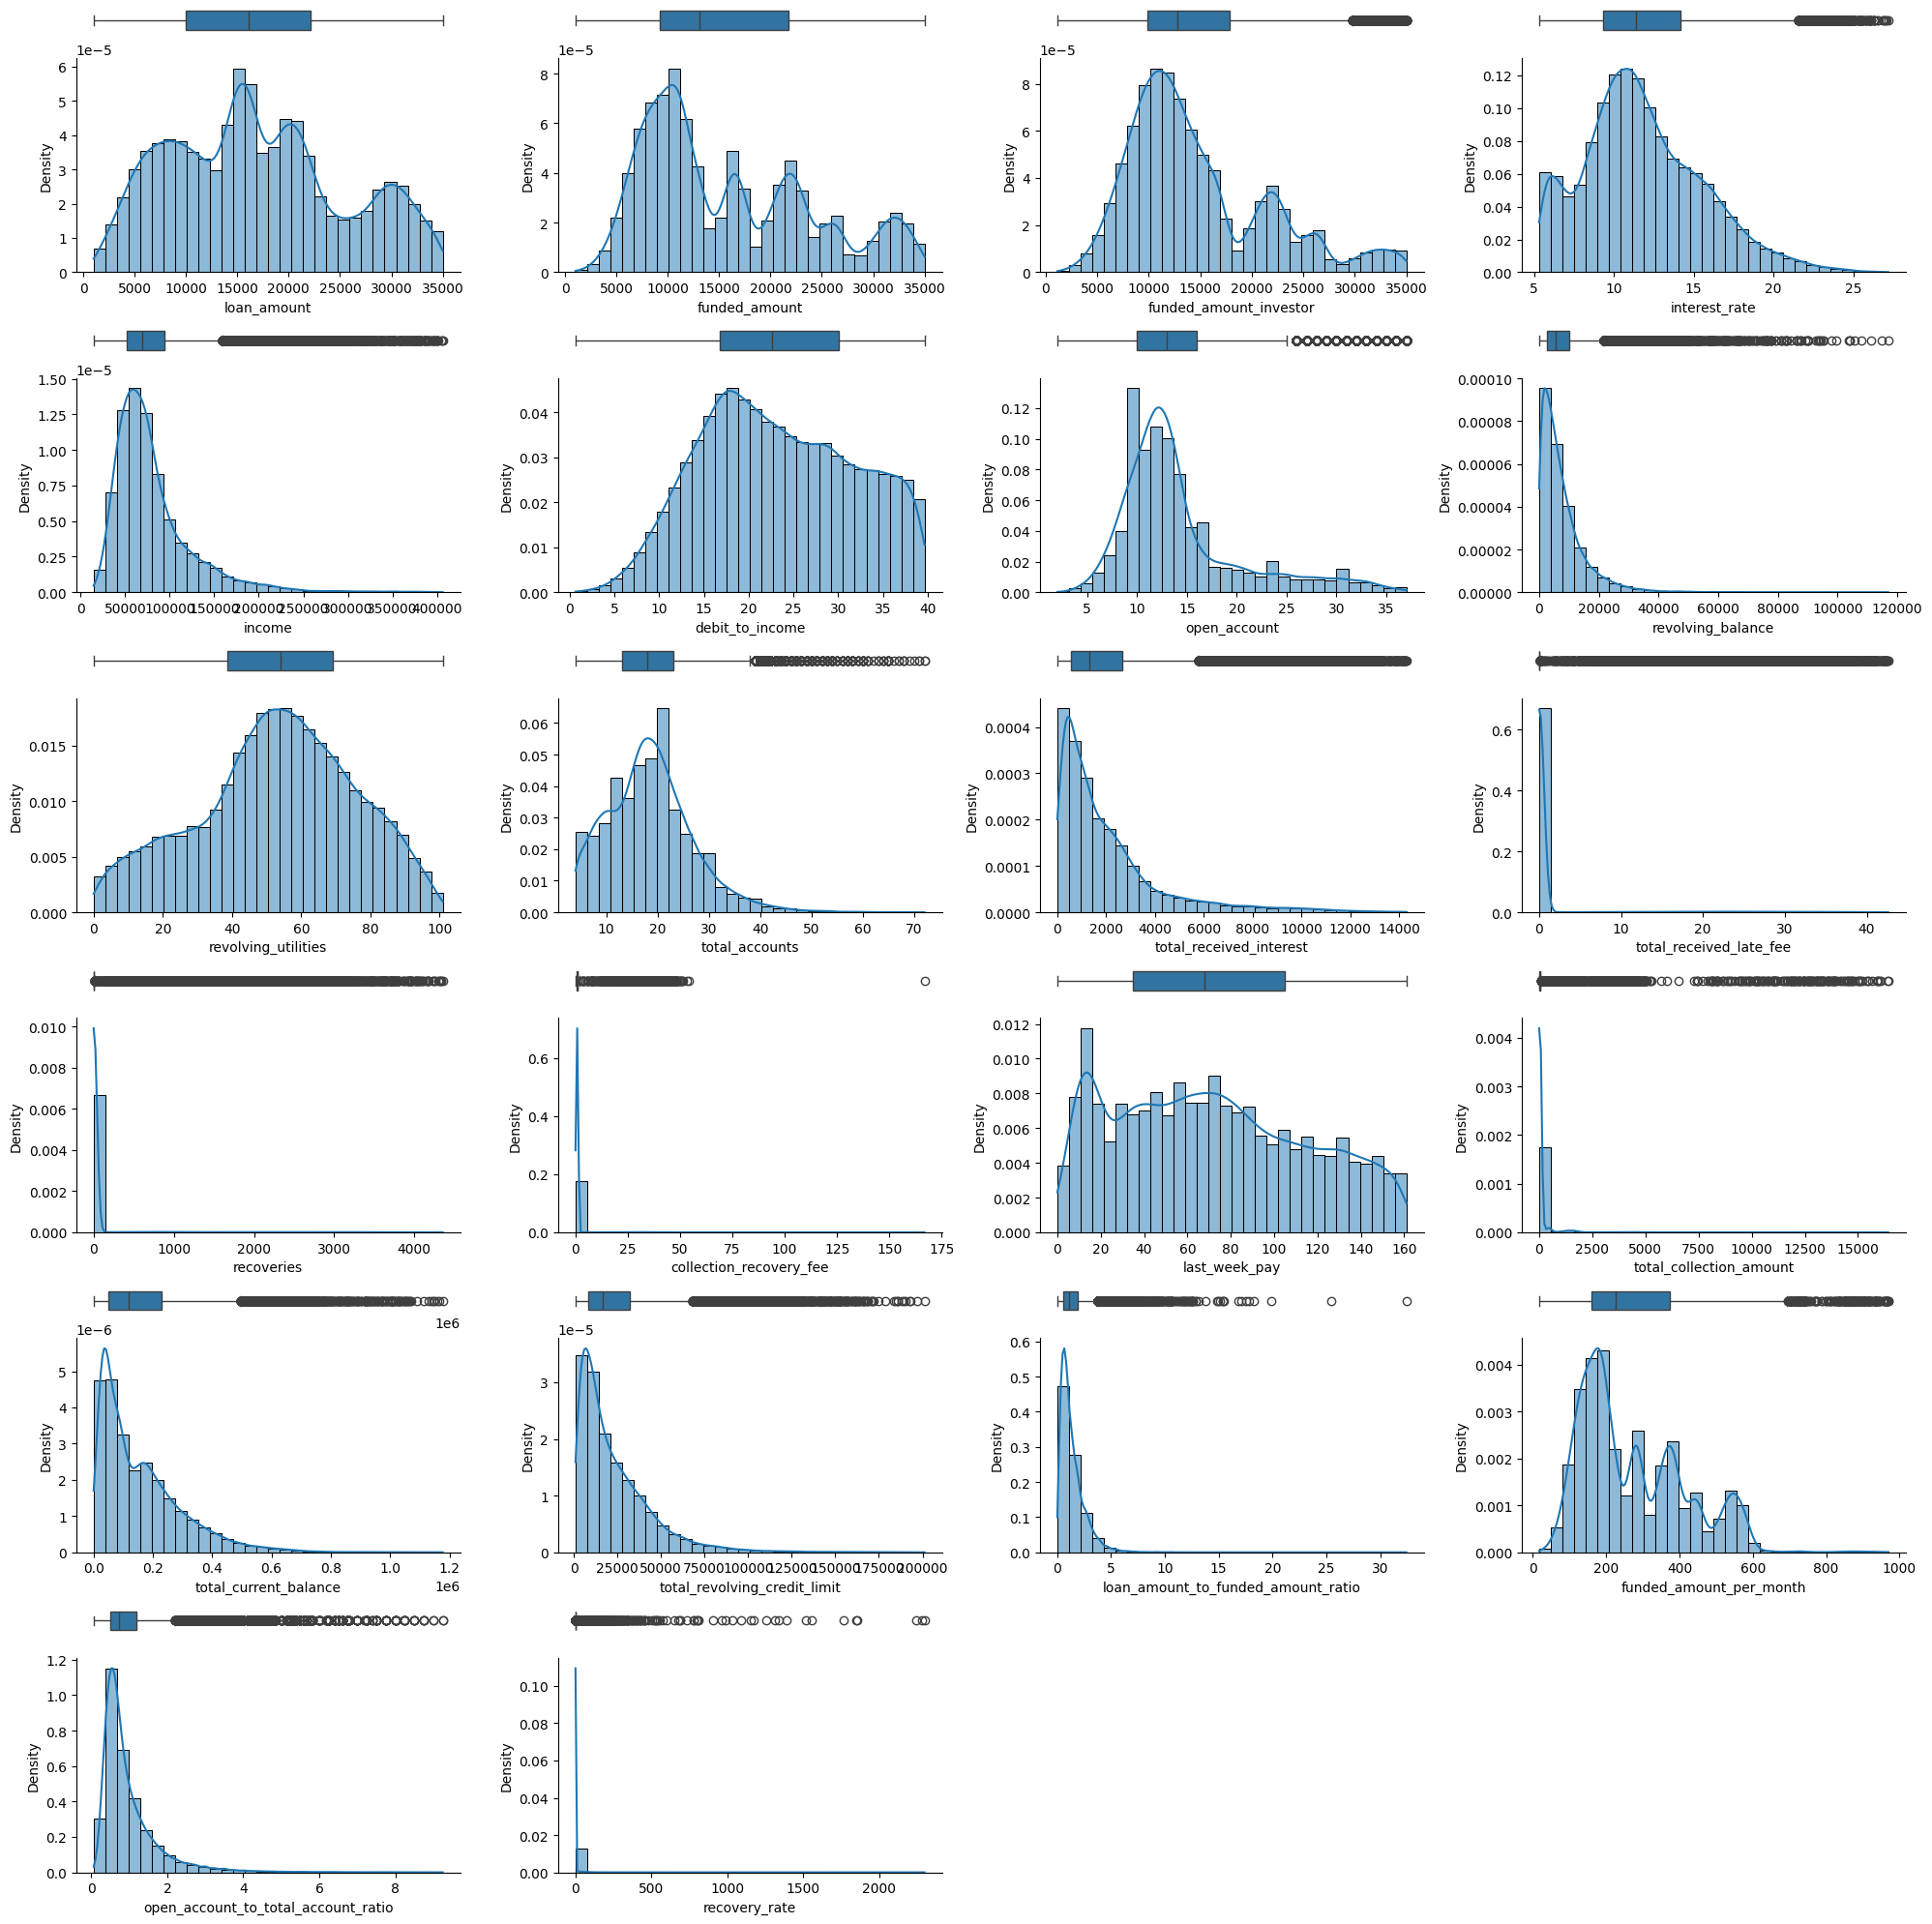

In [37]:
# let's look at the distribution of these variables
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))
ax = ax.ravel()
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])

for i, var in enumerate(continuous_num_vars):
    # Turn off the visible axes in the main subplot
    ax[i].set_visible(False)
    # Create the nested subplots within each cell of the main grid
    gs = ax[i].get_subplotspec().subgridspec(2, 1, height_ratios=[.1, .9])

    # Create boxplot in the first nested subplot, share the x-axis with the histogram
    ax_box = fig.add_subplot(gs[0], sharex=ax[i])
    sns.boxplot(x=X[var], ax=ax_box)
    
    # turn off all the ticks on the axes of the box plot
    ax_box.tick_params(left=False, bottom=False)
    # turn off the title on the box plot
    ax_box.set_xlabel('')
    # turn off all spines (edges) around the box plot
    sns.despine(ax=ax_box, left=True, top=True, right=True, bottom=True)

    # Create histogram in the second nested subplot, share x-axis with the boxplot
    ax_hist = fig.add_subplot(gs[1], sharex=ax_box)
    sns.histplot(x=X[var], bins=30, kde=True, stat='density', ax=ax_hist)
    # Remove x-axis ticks from the boxplot (to avoid double labels)
    plt.setp(ax_box.get_xticklabels(), visible=False)

    # Remove extra spines
    sns.despine(ax=ax_hist)

# Increase distance between rows
plt.subplots_adjust(hspace=2.0)  # Adjust this value as needed
plt.tight_layout()
plt.show()

We see many continuous variables are (heavily) right-skewed. So, before applying optimal binning and WoE transformation, we'll need handle outliers and apply some transformation to normalize the distributions.

In [38]:
# create OutlierCapper class
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=None, upper_quantile=None):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        self.lower_bound_ = X.quantile(self.lower_quantile)
        self.upper_bound_ = X.quantile(self.upper_quantile)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            X_transformed[var] = X[var].clip(lower=self.lower_bound_[var], upper=self.upper_bound_[var])
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [39]:
# create a ColumnTransformer to apply OutlierCapper on our continuous variables

outlier_cap = ColumnTransformer(
    transformers=[
        ('outlier_cap', 
         OutlierCapper(lower_quantile=0.01, upper_quantile=0.99), 
         continuous_num_vars)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

The majority of numerical variables' distributions are right-skewed and leptokurtic. Therefore, before discretizing them and applying encoding methods (like Weight of Evidence), we need to transform these variables. There are several methods as below:

1. The **logarithmic transformation** is typically used to handle positively skewed distribution by compressing the values. It converts a variable X using the natural logarithm.
$$X' = log(X+c)$$
Where:
- $X$ is the original variable (strictly positive)
- $X'$ is the transformed variable
- $c$ is a constant added to X to handle cases where $X <= 0$ (commonly set to 1 to avoid taking log of 0)

2. The **Box-Cox transformation** is more flexible than the log transformation because it inlcudes a parameter $\lambda$ that adjusts the transformation depending on the skewness of the distribution.

$$
X' = 
\begin{cases}
\frac{(X^\lambda - 1)}{\lambda} & \text{if } \lambda \neq 0 \\
log(X) & \text{if } \lambda = 0
\end{cases}
$$

Where:
- $X$ is the original variable (strictly positive)
- $X'$ is the transformed variable
- $\lambda$ is a parameter that can be optimized to best normalize the data

3. The **Yeo-Johnson transformation** is an extension of the Box-Cox transformation that is no longer constrained to positive values.
$$
X' = 
\begin{cases} 
\frac{((X + 1)^{\lambda} - 1)}{\lambda} & \text{if } \lambda \neq 0 \text{ and } X \geq 0 \\ 
-\frac{((-X + 1)^{2 - \lambda} - 1)}{2 - \lambda} & \text{if } \lambda \neq 2 \text{ and } X < 0 \\ 
\ln(X + 1) & \text{if } \lambda = 0 \text{ and } X \geq 0 \\ 
-\ln(-X + 1) & \text{if } \lambda = 2 \text{ and } X < 0 
\end{cases}
$$

In [40]:
# initialize a PowerTransformer to apply Yeo-Johnson transformation
yeojohnson_transformer = ColumnTransformer(
    transformers=[
        ('yeojohnson_transformer', 
         PowerTransformer(method='yeo-johnson', standardize=False), 
         continuous_num_vars)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

Now we can set up the WoETransformer for these continuous variables.

In [41]:
num_continuous_woe = WoETransformer(features=continuous_num_vars,
                                       dtype='numerical',
                                       solver='cp',
                                       monotonic_trend='auto')

Or, instead of WoE transformation, we can apply a standard scaler to these continuous variables

In [44]:
scaler = StandardScaler().set_output(transform='pandas')

In [45]:
# Create the pipeline for numerical variables, we'll do the fit and transform later
num_pipeline = Pipeline(steps=[
    ('num_discrete_woe', num_discrete_woe),
    ('outlier_cap', outlier_cap),
    ('yeojohnson_transformer', yeojohnson_transformer),
    # ('num_continuous_woe', num_continuous_woe),
    ('scaler', scaler),
])

In [46]:
# X_trans_num = num_woe_pipeline.fit_transform(X, y)

In [47]:
# X_trans_num.head()

## 6. Combined Preprocessing Pipeline

Now that we have 2 pipelines for handling categorical and numerical variables, we can combine them into 1 pipeline and use it to transform our variables.

In [48]:
preprocessing_pipeline = Pipeline(steps=[
    ('drop_quasi_constant', drop_quasi_constant),
    ('drop_duplicate', drop_duplicate),
    ('cat_pipeline', cat_pipeline),
    ('num_pipeline', num_pipeline),
])

In [49]:
# fit the combined pipeline
preprocessing_pipeline.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('drop_quasi_constant', DropQuasiConstantFeatures()),
                ('drop_duplicate',
                 DropDuplicateFeatures(missing_values='raise')),
                ('cat_pipeline',
                 Pipeline(steps=[('loan_title_clean', LoanTitleCleanUp()),
                                 ('cat_ordinal_enc',
                                  CustomOrdinalEncoder(features=['grade'])),
                                 ('cat_ordinal_woe',
                                  WoETransformer(dtype='numerical',
                                                 features=['grade'],
                                                 monotonic_tre...
                                                                    'total_received_interest',
                                                                    'total_received_late_fee',
                                                                    'recoveries',
                                                                    'collection_recovery_fee',
                                                                    'last_week_pay',
                                                                    'total_collection_amount',
                                                                    'total_current_balance',
                                                                    'total_revolving_credit_limit',
                                                                    'loan_amount_to_funded_amount_ratio',
                                                                    'funded_amount_per_month',
                                                                    'open_account_to_total_account_ratio',
                                                                    'recovery_rate'])],
                                                    verbose_feature_names_out=False)),
                                 ('scaler', StandardScaler())]))])

In [50]:
# transform our data
X = preprocessing_pipeline.transform(X)

In [51]:
X.head()

,loan_amount,funded_amount,funded_amount_investor,interest_rate,income,debit_to_income,open_account,revolving_balance,revolving_utilities,total_accounts,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,last_week_pay,total_collection_amount,total_current_balance,total_revolving_credit_limit,loan_amount_to_funded_amount_ratio,funded_amount_per_month,open_account_to_total_account_ratio,recovery_rate,term,batch_enrolled,grade,sub_grade,home_ownership,verification_status,loan_title,delinquency_two_years,inquires_six_months,public_record,initial_list_status,collection_12_months_medical,any_inquiries_six_month,any_delinquency_two_years
0,-0.766825,1.637601,-0.153244,-0.086682,1.806014,-0.811296,0.036646,1.793270,0.985193,-1.589102,0.775131,0.726147,-0.134222,0.203527,-0.375962,-0.050138,1.152607,-0.923273,-1.467170,1.601888,1.401504,-0.334981,-0.735496,-0.373976,1.010776,-0.375123,0.865153,0.430709,1.065183,-0.267608,-0.339631,0.270256,0.926572,-0.147527,-0.339631,-1.837976
1,-1.859908,-0.287513,-0.178111,0.215404,-1.251890,-0.924913,-0.178991,-1.464429,1.138613,-0.628716,-0.468159,-0.322600,-0.185591,0.539809,0.887633,0.518414,0.501355,0.248878,-1.488747,-0.315587,0.334240,-0.689876,-0.735496,-1.913604,-0.393305,1.316179,-0.730781,-0.962019,1.065183,0.346415,-0.339631,0.270256,-1.079247,-0.147527,-0.339631,0.544077
2,1.288979,-0.747554,1.089378,0.296507,0.566473,0.602573,0.230716,-0.921286,-2.159127,0.270160,-0.373840,3.735855,0.415143,0.614501,0.026821,0.053838,-0.260062,0.506149,1.428843,-0.772817,-0.160643,0.058486,-0.735496,-0.047001,-1.600187,-0.375123,0.865153,-0.962019,1.065183,0.346415,-0.339631,0.270256,0.926572,-0.147527,-0.339631,0.544077
3,-0.603317,-1.276647,0.670411,1.280968,0.899925,-0.587070,-1.795147,1.035443,0.645998,-0.772979,-1.242836,-0.174893,-2.343129,0.111935,-0.640009,0.230571,-2.065385,1.549194,0.527082,-1.297873,-0.493350,-1.179369,-0.735496,-0.047001,-0.393305,1.316179,0.865153,-0.962019,1.065183,-0.267608,-0.339631,0.270256,0.926572,-0.147527,-0.339631,-1.837976
4,0.112299,-0.095793,0.054564,0.899267,-1.006158,-0.692588,0.036646,-1.048703,1.456649,0.500006,-1.793504,3.735856,2.747072,-0.930714,-1.308962,2.055756,0.089472,0.336948,0.197501,-0.124887,-0.469815,2.780698,-0.735496,0.679004,-0.393305,-0.375123,0.865153,-0.962019,-0.570577,-0.267608,2.944375,-3.700192,0.926572,-0.147527,2.944375,-1.837976


In [52]:
# let's save our pipeline (for reuse later)
import pickle

with open('preprocessing_pipeline.pkl', 'wb') as file:
    pickle.dump(preprocessing_pipeline, file)

In [53]:
# let's also save our preprocessed train dataset
X.to_csv('./data/X.csv', index=False)
y.to_csv('./data/y.csv', index=False)

## 7. Explore feature correlation

In [54]:
X = pd.read_csv('./data/X.csv')
y = pd.read_csv('./data/y.csv')

In [55]:
X.shape, y.shape

((67463, 36), (67463, 1))

In [56]:
X_corr = X.corr()

In [57]:
df_corr = pd.concat([X, y], axis=1).corr()

In [58]:
# sort by absolute correlation coefficient
df_corr['loan_status'].abs().sort_values(ascending=False)

loan_status                            1.000000
batch_enrolled                         0.023961
total_collection_amount                0.023077
term                                   0.021535
home_ownership                         0.015447
initial_list_status                    0.013445
grade                                  0.012705
collection_recovery_fee                0.012584
recovery_rate                          0.009777
open_account                           0.009665
total_current_balance                  0.009190
loan_title                             0.009116
public_record                          0.008774
delinquency_two_years                  0.007450
loan_amount_to_funded_amount_ratio     0.007010
last_week_pay                          0.006323
sub_grade                              0.005742
loan_amount                            0.005674
any_delinquency_two_years              0.004693
revolving_utilities                    0.004183
total_received_late_fee                0

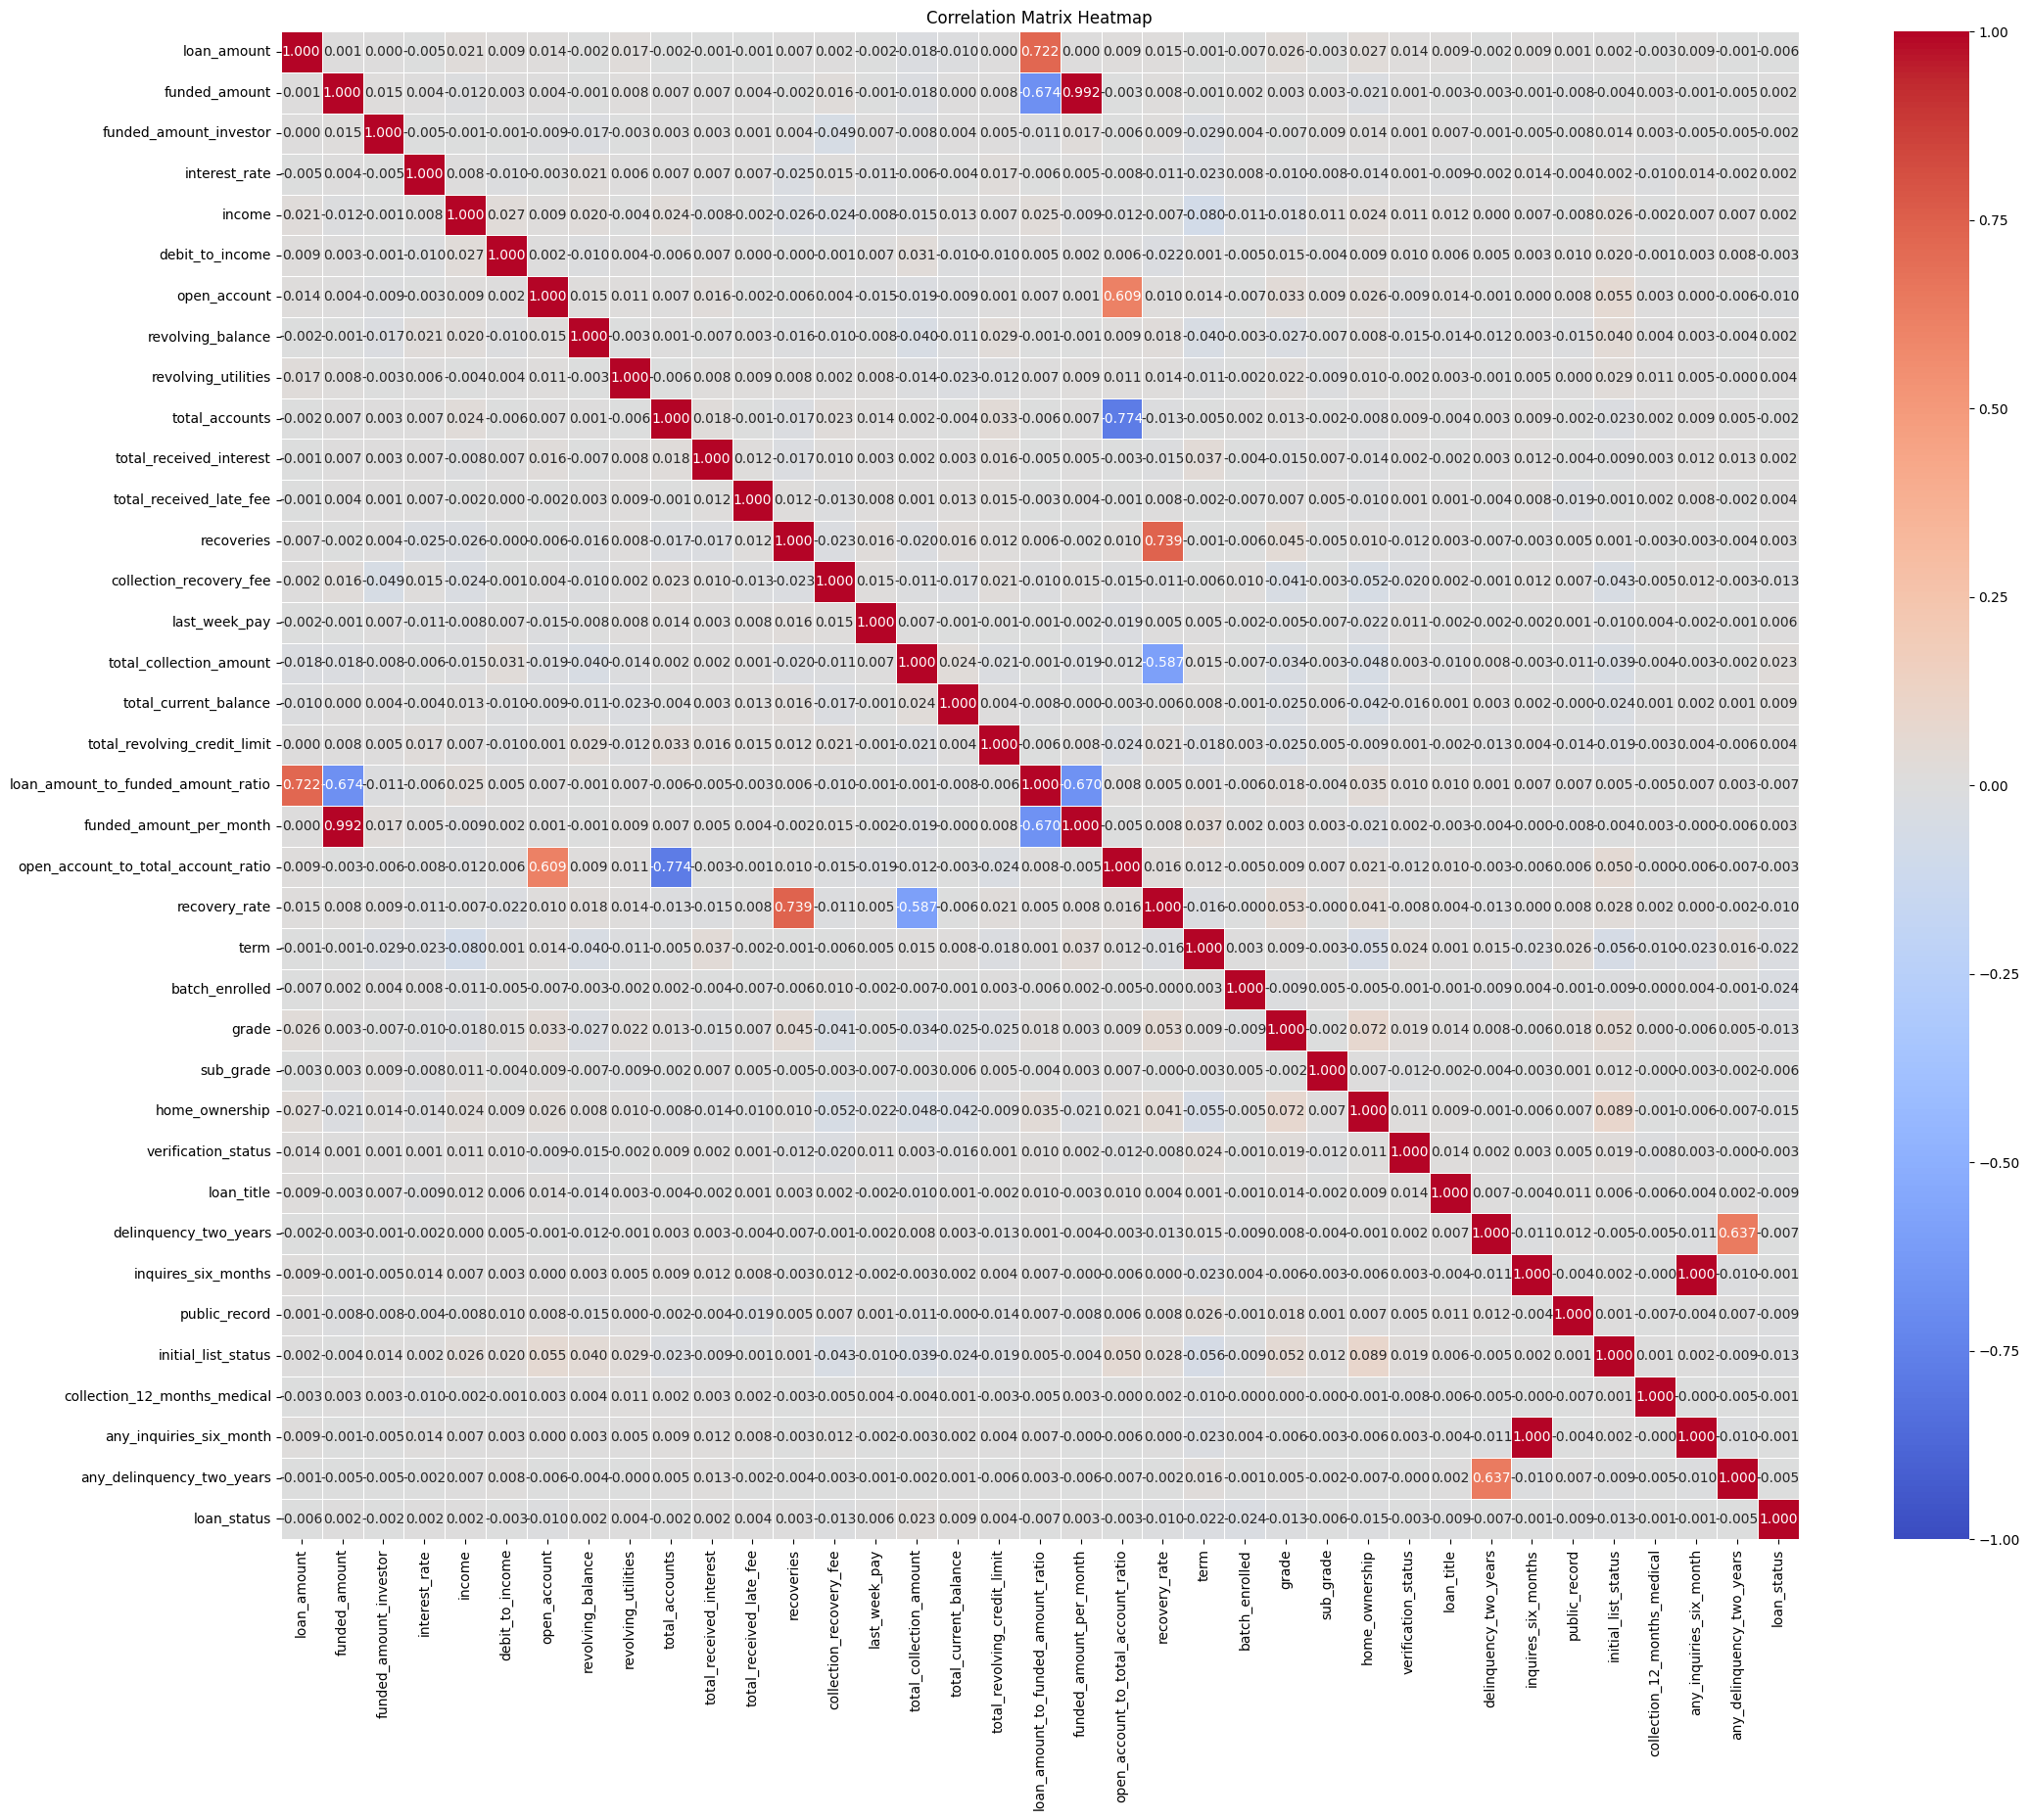

In [59]:
# plot the heatmap of feature correlation
plt.figure(figsize=(25,20))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=.5, fmt='.3f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [60]:
# first, let's separate our data into a train and test set (just a subset of the data that we are leaving out for validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(47224, 36) (47224, 1)
(20239, 36) (20239, 1)


## 8. Removing correlated variables

Since we have created extra features from 

## 8. Sequential Feature Selection

### 8.1. Step forward feature selection

Let's try a step forward feature selection with a Logistic regression model

In [61]:
# define the estimator - Logistic regression model with L1 penalty
lr = LogisticRegression(C=1.0, penalty='l1', 
                                 solver='liblinear', 
                                 max_iter=300,
                                 random_state=42)

sfs = SFS(
    estimator=lr,
    n_features_to_select=15,                          # specify the number of features we want to retain
    tol=None,
    direction='forward',                              # direction of the selection procedure
    scoring='roc_auc',                                # metric to evaluate
    cv=4,                                             # cross-validation fold
    n_jobs=4,
)

In [62]:
sfs = sfs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [63]:
selected_features = sfs.get_feature_names_out()

selected_features

array(['interest_rate', 'open_account', 'revolving_utilities',
       'total_collection_amount', 'total_current_balance',
       'recovery_rate', 'term', 'batch_enrolled', 'grade', 'sub_grade',
       'home_ownership', 'loan_title', 'delinquency_two_years',
       'initial_list_status', 'collection_12_months_medical'],
      dtype=object)

Now we compare the performance of feature subsets versus running on all the features. We will still use the exact same Logistic Regression model set up as above.

In [64]:
# function to train Logistic Regression model and evaludate the performance
def run_logistic_regression(X_train, X_test, y_train, y_test):
    lr = LogisticRegression(C=1.0, penalty='l1', 
                                 solver='liblinear', 
                                 max_iter=300,
                                 random_state=42)
    lr.fit(X_train, y_train)
    # ROC-AUC on train set
    print('Train set')
    pred = lr.predict_proba(X_train)
    print('Logistic regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    # ROC-AUC on test set
    print('Test set')
    pred = lr.predict_proba(X_test)
    print('Logistic regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [65]:
# evaluate the performance of logistic regression run on the subset of selected features
run_logistic_regression(X_train[selected_features],
                        X_test[selected_features],
                        y_train,
                        y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train set
Logistic regression roc-auc: 0.5497144437503176
Test set
Logistic regression roc-auc: 0.5456332509501675


In [66]:
# evaluate the performance of logistic regression run on all features
run_logistic_regression(X_train,
                        X_test,
                       y_train,
                       y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train set
Logistic regression roc-auc: 0.5531888788624023
Test set
Logistic regression roc-auc: 0.5509420839162391


Let's try a different estimator. This time, we'll try a RandomForestClassifier

In [66]:
rf = RandomForestClassifier(n_estimators=20, max_depth=4, random_state=42)

sfs = SFS(
    estimator=rf,
    n_features_to_select=15,                          # specify the number of features we want to retain
    tol=None,
    direction='forward',                              # direction of the selection procedure
    scoring='roc_auc',                                # metric to evaluate
    cv=4,                                             # cross-validation fold
    n_jobs=4,
)

In [67]:
sfs = sfs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

In [68]:
selected_features = sfs.get_feature_names_out()

selected_features

array(['funded_amount', 'funded_amount_investor', 'income',
       'open_account', 'revolving_balance', 'revolving_utilities',
       'total_accounts', 'total_received_late_fee',
       'collection_recovery_fee', 'total_collection_amount',
       'open_account_to_total_account_ratio', 'term', 'home_ownership',
       'initial_list_status', 'collection_12_months_medical'],
      dtype=object)

Now we compare the performance of feature subsets versus running on all the features. We will still use the exact same Random Forest model set up as above.

In [69]:
# function to train Random Forest model and evaludate the performance
def run_random_forest(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=20, max_depth=4, random_state=42)
    rf.fit(X_train, y_train)
    # ROC-AUC on train set
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Logistic regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    # ROC-AUC on test set
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Logistic regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [70]:
# evaluate the performance of Random Forest run on the subset of selected features
run_random_forest(X_train[selected_features],
                  X_test[selected_features],
                  y_train,
                  y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train set
Logistic regression roc-auc: 0.5827615848978356
Test set
Logistic regression roc-auc: 0.5482207302548239


In [71]:
# evaluate the performance of Random Forest run on all features
run_random_forest(X_train,
                  X_test,
                  y_train,
                  y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train set
Logistic regression roc-auc: 0.6023534205163821
Test set
Logistic regression roc-auc: 0.558512193015768


In [72]:
# # test this pipeline on our test set
# with open('preprocessing_pipeline.pkl', 'rb') as file:
#     preprocessing_pipeline = pickle.load(file)

In [73]:
# # load the test set
# df_test = pd.read_csv('./data/test.csv')

In [74]:
# # check the number of rows and columns
# df_test.shape

In [75]:
# # Displays column names, complete (non-missing) cases per column, and datatype per column.
# df_test.info()

In [76]:
# # let's separate the data into target and variables
# target = 'Loan Status'

# y_test = df_test[target]
# X_test = df_test[[var for var in df_test.columns if var not in [target, 'ID']]]

In [77]:
# X_test.shape, y_test.shape

In [78]:
# # use the pipeline to transform the test set
# X_test = preprocessing_pipeline.transform(X_test)

In [79]:
# X_test.shape

In [80]:
# X_test.head()

In [81]:
# X_test.describe().T